# Analysis of US Presidential Speeches

The speeches are downloaded from NLTK's "inaugural" corpus, along with the Presidents' last names and the year of speech.
I have scrapped a wikipedia table from the wikipedia page https://en.wikipedia.org/wiki/President_of_the_United_States to extract the names of the different parties the Presidents were/are affiliated to.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import rcParams
import os
import re
%matplotlib inline
os.chdir(r'C:\Users\sriva\Desktop\ISM6930_Text_Analytics\Raj_Ankit_Assignment02')

### Corpus preparation

In [2]:
# Imported the inaugural corpus from nltk.corpus
import nltk
from nltk.corpus import inaugural

# Created a dataframe to store the Corpus data, with values like President's last name, year of speech and speech text
# Speech text, date of speech and president names are stored in 3 lists
# Used a for loop to populate the lists
speech_text = []
date_of_speech = []
president = []
for fileid in inaugural.fileids():
    speech_text.append(inaugural.raw(fileid))
    date_of_speech.append(fileid[0:4])
    president.append(fileid[5:-4])

# Concated all the lists after converting them to pandas series to populate the corpus dataframe    
inaugural_speech_dataset = pd.concat([pd.Series(president), pd.Series(date_of_speech), pd.Series(speech_text)], axis = 1)
inaugural_speech_dataset.columns = ['PresidentLastName', 'YearOfSpeech', 'SpeechText']
inaugural_speech_dataset.head()

,PresidentLastName,YearOfSpeech,SpeechText
0,Washington,1789,Fellow-Citizens of the Senate and of the House...
1,Washington,1793,"Fellow citizens, I am again called upon by the..."
2,Adams,1797,"When it was first perceived, in early times, t..."
3,Jefferson,1801,Friends and Fellow Citizens:\n\nCalled upon to...
4,Jefferson,1805,"Proceeding, fellow citizens, to that qualifica..."


##### Used requests & BeautifulSoup to extract a wikipedia table containing the affiliated parties data

In [3]:
import requests
from bs4 import BeautifulSoup

url = 'https://en.wikipedia.org/wiki/President_of_the_United_States'
website = requests.get(url)
#website.text

In [4]:
# Created a soup object to parse the text from the website
soup = BeautifulSoup(website.text, 'html.parser')
soup.title

<title>President of the United States - Wikipedia</title>

In [5]:
# Created a variable to store the tables of the class wikitable from the soup object
my_president_table = soup.find('table', {'class':'wikitable'})
#my_president_table

In [6]:
# Stored all the row tags from my_president_table in a new variable and created a new list to store the data in each row
# Iterated over a for loop to find out the value within each table division and append to the list
rows = my_president_table.find_all('tr')
president_data = []
for r in rows:
    cells = r.find_all('td')
    
    #Except the first row, all the rows have 4 columns
    if len(cells) == 4:
        value1 = cells[0].find(text=True)
        value2 = cells[1].find(text=True)
        value3 = cells[2].find(text=True)
        value4 = cells[3].find_all(text=True)
        president_data.append([value1, value2, value3, value4])

In [7]:
# Cleaned new line characters in the data cells
for row in range(len(president_data)):
    for col in range(4):
        if col == 3:
            president_data[row][col] = [value.replace('\xa0', ' ') for value in president_data[row][col]]
            president_data[row][col] = [value.replace('\n', ' ') for value in president_data[row][col]]
            president_data[row][col] = [value.replace('[D]', ' ') for value in president_data[row][col]]
            president_data[row][col] = [value.replace('[E]', ' ') for value in president_data[row][col]]
        else:
            president_data[row][col] = president_data[row][col].replace('\n', '')

# Stored the list data in a pandas dataframe
president_df = pd.DataFrame(president_data)
president_df.columns = ['Index', 'Party', 'NoOfPresidents', 'Presidents']
president_df

,Index,Party,NoOfPresidents,Presidents
0,,Republican,19,"[Chester A. Arthur, , , George H. W. Bush, , ,..."
1,,Democratic,14,"[James Buchanan, , , Jimmy Carter, , , Grover ..."
2,,Democratic-Republican,4,"[John Quincy Adams, , , Thomas Jefferson, , , ..."
3,,Whig,4,"[Millard Fillmore, , , William Henry Harrison,..."
4,,Federalist,1,"[John Adams, ]"
5,,National Union,1,"[Andrew Johnson, , ]"
6,,None,1,"[George Washington, ]"


In [8]:
# Removed all the bad characters from the column Presidents of the dataframe
# Stored the list of Republican and Democratic Presidents in two separate lists
list_of_republican_presidents = str(president_df.loc[president_df['Party'] == 'Republican', 'Presidents'].values[0])
list_of_democratic_presidents = str(president_df.loc[president_df['Party'] == 'Democratic', 'Presidents'].values[0])

bad_characters = ["[", "'", ",", "]"]
list_of_republican_presidents = ''.join([v for v in list_of_republican_presidents if v not in bad_characters]).split()
list_of_democratic_presidents = ''.join([v for v in list_of_democratic_presidents if v not in bad_characters]).split()

In [9]:
# Created a new column to store the affiliated parties, and used if-else with a for loop to check for their affiliations
inaugural_speech_dataset['PartyAffiliation'] = ''
for i in inaugural_speech_dataset['PresidentLastName'].values:
    if i in list_of_republican_presidents:
        inaugural_speech_dataset.loc[inaugural_speech_dataset['PresidentLastName'] == i, 'PartyAffiliation'] = 'Republican'
    elif i in list_of_democratic_presidents:
        inaugural_speech_dataset.loc[inaugural_speech_dataset['PresidentLastName'] == i, 'PartyAffiliation'] = 'Democratic'
    else:
        inaugural_speech_dataset.loc[inaugural_speech_dataset['PresidentLastName']==i, 'PartyAffiliation'] = 'Other'
inaugural_speech_dataset.head(15)

,PresidentLastName,YearOfSpeech,SpeechText,PartyAffiliation
0,Washington,1789,Fellow-Citizens of the Senate and of the House...,Other
1,Washington,1793,"Fellow citizens, I am again called upon by the...",Other
2,Adams,1797,"When it was first perceived, in early times, t...",Other
3,Jefferson,1801,Friends and Fellow Citizens:\n\nCalled upon to...,Other
4,Jefferson,1805,"Proceeding, fellow citizens, to that qualifica...",Other
5,Madison,1809,Unwilling to depart from examples of the most ...,Other
6,Madison,1813,About to add the solemnity of an oath to the o...,Other
7,Monroe,1817,I should be destitute of feeling if I was not ...,Other
8,Monroe,1821,"Fellow citizens, I shall not attempt to descri...",Other
9,Adams,1825,In compliance with an usage coeval with the ex...,Other


##### As the basic corpus that I would be using is complete, exported the corpus as a csv file

In [10]:
inaugural_speech_dataset.to_csv('Raj_Ankit_Inaugural_Speech_Corpus.csv')

In [11]:
from string import punctuation

# Created a function clean_speech_text() that takes an input speech text, clean it of punctuations
# And everything that isn't a word, and returns a cleaned text
def clean_speech_text(text):
    text = re.sub(r'['+ punctuation + '’—”'+']', "", text.lower())
    text = re.sub(r'\W+', ' ', text)
    return text

# Created a new variable, CleanedSpeechText, that takes the output from the clean_speech_text()
inaugural_speech_dataset['CleanedSpeechText'] = inaugural_speech_dataset['SpeechText'].map(lambda x : clean_speech_text(x))

# Created a new variable to store the total number of words used in each of the speeches
inaugural_speech_dataset['NoOfWords'] = inaugural_speech_dataset['CleanedSpeechText'].apply(lambda x : len(x.split()))

# Created a new variable to store the number of unique words used in each of the speeches
inaugural_speech_dataset['NoOfUniqueWords'] = inaugural_speech_dataset['CleanedSpeechText'].str.split().apply(lambda x : len(set(x)))
inaugural_speech_dataset.head()

,PresidentLastName,YearOfSpeech,SpeechText,PartyAffiliation,CleanedSpeechText,NoOfWords,NoOfUniqueWords
0,Washington,1789,Fellow-Citizens of the Senate and of the House...,Other,fellowcitizens of the senate and of the house ...,1430,595
1,Washington,1793,"Fellow citizens, I am again called upon by the...",Other,fellow citizens i am again called upon by the ...,135,90
2,Adams,1797,"When it was first perceived, in early times, t...",Other,when it was first perceived in early times tha...,2318,794
3,Jefferson,1801,Friends and Fellow Citizens:\n\nCalled upon to...,Other,friends and fellow citizens called upon to und...,1726,681
4,Jefferson,1805,"Proceeding, fellow citizens, to that qualifica...",Other,proceeding fellow citizens to that qualificati...,2166,775


Although at first, I focussed on the total vocabulary of the Presidents for all of their speeches combined as some of the Presidents were re-elected, I noticed some of the Presidents have the same surname, like George W. Bush and his father George H.W. Bush, and William Henry Harrison and Benjamin Harrison, to state a few. And we only have the last name of the Presidents, so I decided to focus on the vocabulary for each of their speech.

### 1. Which president has the most vocabulary as evident from their inaugural speeches, and which presidents has the least vocabulary? On average, do Democratic, Republican, or other presidents have higher vocabulary?

In [12]:
# Found out the Presidents with the most and the least vocabulary
president_with_max_vocab = inaugural_speech_dataset.loc[inaugural_speech_dataset['NoOfUniqueWords'] == inaugural_speech_dataset['NoOfUniqueWords'].max(), 'PresidentLastName']
president_with_min_vocab = inaugural_speech_dataset.loc[inaugural_speech_dataset['NoOfUniqueWords'] == inaugural_speech_dataset['NoOfUniqueWords'].min(), 'PresidentLastName']

print('President %s'%president_with_max_vocab.to_string(index=False), 'has the most vocabulary. \n'
'President %s'%president_with_min_vocab.to_string(index=False), 'has the least vocabulary.')

President  Harrison has the most vocabulary. 
President  Washington has the least vocabulary.


In [13]:
# Grouped the speech data to find out which party presidents have, on average, a higher vocabulary.
grouped_inaugural_speech_data = inaugural_speech_dataset.groupby('PartyAffiliation')
print(grouped_inaugural_speech_data['NoOfUniqueWords'].agg('mean'))

PartyAffiliation
Democratic    713.588235
Other         737.250000
Republican    806.137931
Name: NoOfUniqueWords, dtype: float64


We can observe from the data above that on average, Republican Presidents have a higher vocabulary.

##### Created a new variable to store the Presidents' last names and their respective years of speeches to better analyze their vocabulary in each year

In [14]:
# Created a new dataframe and assigned it the concatenated President name and year values
president_vocab_data = inaugural_speech_dataset.assign(PresidentNameYear = 'President ' + inaugural_speech_dataset['PresidentLastName'] \
                                                 + ', ' + inaugural_speech_dataset['YearOfSpeech'])
president_vocab_data.head()

,PresidentLastName,YearOfSpeech,SpeechText,PartyAffiliation,CleanedSpeechText,NoOfWords,NoOfUniqueWords,PresidentNameYear
0,Washington,1789,Fellow-Citizens of the Senate and of the House...,Other,fellowcitizens of the senate and of the house ...,1430,595,"President Washington, 1789"
1,Washington,1793,"Fellow citizens, I am again called upon by the...",Other,fellow citizens i am again called upon by the ...,135,90,"President Washington, 1793"
2,Adams,1797,"When it was first perceived, in early times, t...",Other,when it was first perceived in early times tha...,2318,794,"President Adams, 1797"
3,Jefferson,1801,Friends and Fellow Citizens:\n\nCalled upon to...,Other,friends and fellow citizens called upon to und...,1726,681,"President Jefferson, 1801"
4,Jefferson,1805,"Proceeding, fellow citizens, to that qualifica...",Other,proceeding fellow citizens to that qualificati...,2166,775,"President Jefferson, 1805"


### 2. Create a barplot of presidential vocabulary from the earliest president (Washington) to the latest (Trump) in this sample of presidential speeches. Color code this barplot as blue for Democrats, red for Republican, and gray for Others.

In [1]:
# Created barplots to observe the vocabularies of the different US Presidents over the years
colors = ['#A9A9A9', '#0000FF', '#FF0000']

plt.figure(figsize = (16, 8))
plt.xticks(rotation = 90)

ax = sb.barplot(x = 'PresidentNameYear', y = 'NoOfUniqueWords', hue = 'PartyAffiliation', data = president_vocab_data, palette=colors)
ax.set_title('Vocabulary of US Presidents', fontsize=18)
ax.set_ylabel('Vocabulary', fontsize=14)
ax.set_xlabel('Presidents', fontsize=14)
plt.show()

NameError: name 'plt' is not defined

### 3. What are the five most frequently used words (exclusive of stop words) used by each president? Do Democratic presidents use a different set of words than Republican presidents? 

In [16]:
from collections import Counter
stopwords = nltk.corpus.stopwords.words('english')

# Created a function to get the 5 most frequent used words by each President
# Removed stop words and anything that isn't an alphanumeric character from their speech text
# Used Counter to get the 5 most common words
def get_most_frequent_words(text):
    words = nltk.tokenize.word_tokenize(text)
    words = [w for w in words if w not in stopwords]
    words = [w for w in words if w.isalpha()]
    most_freq = Counter(words).most_common(5)
    most_freq = ', '.join(w[0] for w in most_freq)
    return most_freq

president_vocab_data['Top5Freqwords'] = president_vocab_data['CleanedSpeechText'].map(lambda x : get_most_frequent_words(x))
president_vocab_data[['PresidentNameYear', 'Top5Freqwords']].style.hide_index()

PresidentNameYear,Top5Freqwords
"President Washington, 1789","every, government, public, may, present"
"President Washington, 1793","shall, oath, fellow, citizens, called"
"President Adams, 1797","people, government, may, nations, country"
"President Jefferson, 1801","government, us, may, let, shall"
"President Jefferson, 1805","public, citizens, may, fellow, state"
"President Madison, 1809","nations, public, country, well, peace"
"President Madison, 1813","war, country, united, every, british"
"President Monroe, 1817","great, states, government, people, us"
"President Monroe, 1821","great, states, would, united, war"
"President Adams, 1825","union, government, upon, rights, peace"


In [17]:
grouped_president_vocab_data = president_vocab_data.groupby('PartyAffiliation')
for party in grouped_president_vocab_data.groups.keys():
    party_vocab_data = grouped_president_vocab_data.get_group(party)
    party_unique_words = party_vocab_data['Top5Freqwords'].str.cat(sep = ' ')
    print('Top 5 frequent words used by %s'%party,'party presidents are: ')
    print(get_most_frequent_words(party_unique_words))
    print('\n')

Top 5 frequent words used by Democratic party presidents are: 
people, us, government, must, shall


Top 5 frequent words used by Other party presidents are: 
government, country, may, every, public


Top 5 frequent words used by Republican party presidents are: 
people, government, us, upon, world




It is interesting to observe that 3 out of 5 most frequent words used by both the Democratic and the Republican Presidents are the same.

### 4. Compute a sentiment (positive/negative) for each president, and draw three barplots of Democratic, Republican, and other presidents in chronological order. Which of these groups have higher mean sentiment score? Who are the top three presidents with the highest positive sentiment in each group?

In [18]:
# Imported SentimentIntensityAnalyzer from nltk
# Created a new vartiable to store the sentiments of the Presidents' speeches
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()
president_vocab_data['Sentiments'] = ''

# Used a for loop to calculate the polarity score of each of the President's speech and populate the Sentiments columns
for index in president_vocab_data.index:
    polarity_score = sentiment_analyzer.polarity_scores(president_vocab_data.loc[index, 'CleanedSpeechText'])
    sentiment = polarity_score['compound']
    president_vocab_data.loc[index, 'Sentiments'] = sentiment
    pos_sentiments = polarity_score['pos']
    president_vocab_data.loc[index, 'PosSentiments'] = pos_sentiments
president_vocab_data.head()

,PresidentLastName,YearOfSpeech,SpeechText,PartyAffiliation,CleanedSpeechText,NoOfWords,NoOfUniqueWords,PresidentNameYear,Top5Freqwords,Sentiments,PosSentiments
0,Washington,1789,Fellow-Citizens of the Senate and of the House...,Other,fellowcitizens of the senate and of the house ...,1430,595,"President Washington, 1789","every, government, public, may, present",0.9999,0.239
1,Washington,1793,"Fellow citizens, I am again called upon by the...",Other,fellow citizens i am again called upon by the ...,135,90,"President Washington, 1793","shall, oath, fellow, citizens, called",0.5719,0.082
2,Adams,1797,"When it was first perceived, in early times, t...",Other,when it was first perceived in early times tha...,2318,794,"President Adams, 1797","people, government, may, nations, country",1,0.258
3,Jefferson,1801,Friends and Fellow Citizens:\n\nCalled upon to...,Other,friends and fellow citizens called upon to und...,1726,681,"President Jefferson, 1801","government, us, may, let, shall",0.9998,0.220
4,Jefferson,1805,"Proceeding, fellow citizens, to that qualifica...",Other,proceeding fellow citizens to that qualificati...,2166,775,"President Jefferson, 1805","public, citizens, may, fellow, state",0.9998,0.177


In [19]:
# To make sure we have the correct datatypes for our analysis
president_vocab_data.dtypes

PresidentLastName     object
YearOfSpeech          object
SpeechText            object
PartyAffiliation      object
CleanedSpeechText     object
NoOfWords              int64
NoOfUniqueWords        int64
PresidentNameYear     object
Top5Freqwords         object
Sentiments            object
PosSentiments        float64
dtype: object

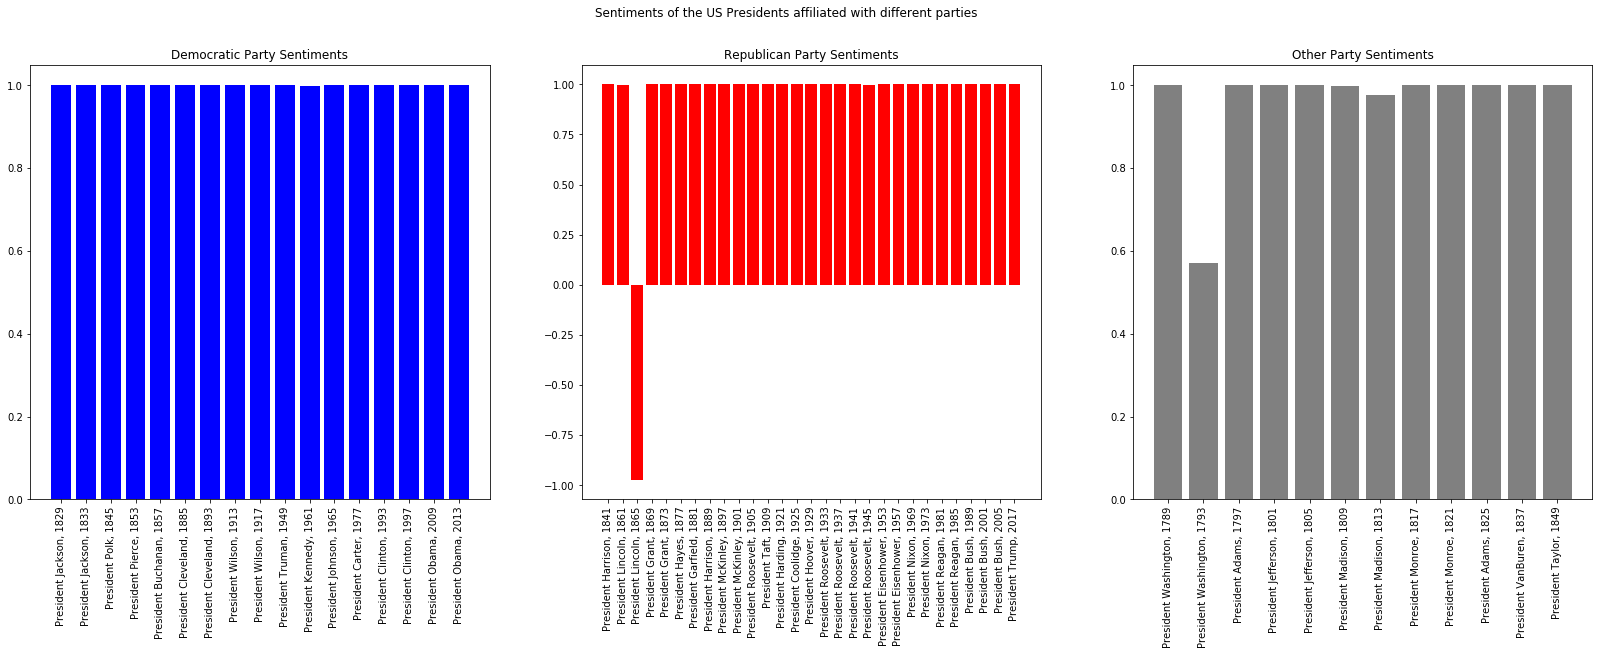

In [20]:
# Updated the datatype of the Sentiments to numeric
president_vocab_data['Sentiments'] = pd.to_numeric(president_vocab_data['Sentiments'])

# Grouped the data for the parties and figured stored each party data in a separate dataframe
grouped_president_vocab_data = president_vocab_data.groupby('PartyAffiliation')
democratic_vocab_data = grouped_president_vocab_data.get_group('Democratic')
republican_vocab_data = grouped_president_vocab_data.get_group('Republican')
other_vocab_data = grouped_president_vocab_data.get_group('Other')

# Plot of president sentiments from different parties
plt.figure(figsize = (28, 8))

plt.subplot(131)
plt.bar(democratic_vocab_data['PresidentNameYear'], democratic_vocab_data['Sentiments'], color = 'blue')
plt.xticks(rotation='vertical')
plt.title('Democratic Party Sentiments')

plt.subplot(132)
plt.bar(republican_vocab_data['PresidentNameYear'], republican_vocab_data['Sentiments'], color = 'red')
plt.xticks(rotation='vertical')
plt.title('Republican Party Sentiments')

plt.subplot(133)
plt.bar(other_vocab_data['PresidentNameYear'], other_vocab_data['Sentiments'], color = 'grey')
plt.xticks(rotation='vertical')
plt.title('Other Party Sentiments')

plt.suptitle('Sentiments of the US Presidents affiliated with different parties')
plt.show()

In [21]:
# Calculated the mean sentiment of each party
grouped_president_vocab_data['Sentiments'].agg('mean')

PartyAffiliation
Democratic    0.999724
Other         0.962142
Republican    0.931748
Name: Sentiments, dtype: float64

As we can observe, Democratic Party Presidents seem to have the highest mean sentiment score of 0.999724.

In [22]:
# Dropped duplicate rows with same president names, party affiliations and sentiment polarities
# Sorted the vocab data by sentiments and party affiliations from bottom to top
# Stored the top 3 President Names and Years, Party Affiliations and Sentiments in a new dataframe
president_vocab_data = president_vocab_data.drop_duplicates(['PresidentLastName', 'PartyAffiliation', 'PosSentiments'])
sorted_vocab_data = president_vocab_data.sort_values(by=['PosSentiments', 'PartyAffiliation'],ascending = False).groupby('PartyAffiliation')['PresidentNameYear', 'PartyAffiliation', 'PosSentiments'].head(3)
print('Top 3 presidents with the highest positive sentiment in each party are: ')
sorted_vocab_data.style.hide_index()

Top 3 presidents with the highest positive sentiment in each party are: 


PresidentNameYear,PartyAffiliation,PosSentiments
"President Carter, 1977",Democratic,0.284
"President Bush, 2005",Republican,0.277
"President Truman, 1949",Democratic,0.274
"President Eisenhower, 1957",Republican,0.273
"President Eisenhower, 1953",Republican,0.263
"President Adams, 1797",Other,0.258
"President Washington, 1789",Other,0.239
"President Taylor, 1849",Other,0.237
"President Cleveland, 1885",Democratic,0.224
